# Playground
This notebook serves as a playground to test out initial ideas. We have a look at the hot spots for accidents by looking at a map of NY.

## 1 Import packages

In [1]:
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas.datasets as gpd_datasets

## 2 Import and prepare data

In [2]:
# Load exemplary citibike data sets 1 and 2 about bike trips
path_c1 = "../0_data/2023-citibike-tripdata/202301-citibike-tripdata_1.csv"
path_c2 = "../0_data/2023-citibike-tripdata/202301-citibike-tripdata_2.csv"
df_c1 = pd.read_csv(path_c1,dtype={"start_station_id": "string", "end_station_id": "string"})
df_c2 = pd.read_csv(path_c2,dtype={"start_station_id": "string", "end_station_id": "string"})

# Combine Citibike data sets 1 and 2
df_c = pd.concat([df_c1, df_c2], ignore_index=True)

In [ ]:
# Load police data set about accidents
path_p = "../0_data/2025-police-data/Motor_Vehicle_Collisions_-_Crashes_20250908.csv"
df_p = pd.read_csv(path_p)

/var/folders/sq/4718j4291l3grg5pb__586wm0000gn/T/ipykernel_951/3234936346.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_p = pd.read_csv(path_p)


Next: Investigate column 3 (ZIP CODE) in police data

In [6]:
# Count rows with NA and "     "
print("Number of rows with NA or multiple spaces in ZIP CODE column BEFORE type conversion:\n",
    df_p["ZIP CODE"].isna().sum() 
    + 
    (df_p["ZIP CODE"] == "     ").sum()
    )

Number of rows with NA or multiple spaces in ZIP CODE column BEFORE type conversion:
 677141


In [7]:
# Convert to numeric and set errors to NA, e.g., rows with "     "
df_p["ZIP CODE"] = pd.to_numeric(df_p["ZIP CODE"], errors="coerce")
# Convert to integer type
df_p["ZIP CODE"] = df_p["ZIP CODE"].astype("Int64")

In [8]:
# Count rows with NA and "     ", to double check all errors were converted to NA
print("Number of rows with NA or multiple spaces in ZIP CODE column AFTER type conversion:\n",
    df_p["ZIP CODE"].isna().sum() 
    + 
    (df_p["ZIP CODE"] == "     ").sum()
    )

Number of rows with NA or multiple spaces in ZIP CODE column AFTER type conversion:
 677141


## 3 Discover data visually
Where are the hot spots for accidents and rides finished? At crosssections? Hot spots?

In [ ]:
# Function to drop rows with NA in specified columns
def prep_data(df:pd.DataFrame, col_lat:str, col_long:str, col_date:str):
    '''
    Prepares data for plotting, by following these steps: Drop NA in col_lat and col_long, filter for col_lat and col_long within NYC bounds, Format Pandas DataFrame to GeoDataFrame, filter for events in 2023. Notice in the citibike data we use the end coordinates, as we want to compare these events to the accidents.
    Args:
        df:pd.DataFrame - input data frame (e.g., police or citibike data)
        col_lat:str - name of column with latitude values (e.g., "end_lat" or "LATITUDE")
        col_long:str - name of column with longitude values (e.g., "end_lng" or "LONGITUDE")
        col_date:str - name of column with date values (e.g., "end_time" or "CRASH DATE")
    Returns:
        gdf:gdf.GeoDataFrame - prepared GeoDataFrame for plotting
    '''
    
    # Drop NA
    df = df.dropna(subset=[col_lat, col_long])
    # Drop anything out side NYC bounds: 40.5 < lat < 40.9 & -74.3 < long < -73.7
    df = df[(df[col_lat] > 40.5) & (df[col_lat] < 40.9) & (df[col_long] > -74.3) & (df[col_long] < -73.7)]
    # Format to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df[col_long], df[col_lat]), crs="EPSG:4326"
    )
    # Filter for events in 2023
    gdf = gdf[gdf[col_date].str.contains("2023")]

    return gdf

In [8]:
# Prepare Citibike data for plot
gdf_c = prep_data(df_c, "end_lat", "end_lng", "ended_at")

# Prepare Police data for plot
gdf_p = prep_data(df_p, "LATITUDE", "LONGITUDE", "CRASH DATE")

In [9]:
# Load the NYC boundaries
df = gpd.read_file(geodatasets.get_path("nybb"))

# Make sure nybb is also in same CRS
df = df.to_crs("EPSG:4326")

In [10]:
# Load touristic attractions data
data = {
    "Attraction": [
        "Statue of Liberty",
        "Empire State Building",
        "One World Observatory (One WTC)",
        "9/11 Memorial & Museum",
        "Times Square",
        "Central Park",
        "Brooklyn Bridge",
        "Metropolitan Museum of Art",
        "Rockefeller Center",
        "Broadway Theatre District"
    ],
    "col_lat": [
        40.6892532,
        40.7484421,
        40.7130200,
        40.7114490,
        40.7588960,
        40.7828647,
        40.7060860,
        40.7794366,
        40.7587402,
        40.7590110
    ],
    "col_long": [
        -74.0445482,
        -73.9856589,
        -74.0131910,
        -74.0138550,
        -73.9851300,
        -73.9653551,
        -73.9968640,
        -73.9632440,
        -73.9786740,
        -73.9844722
    ]
}

df_t = pd.DataFrame(data)
gdf_t = gpd.GeoDataFrame(
        df_t, geometry=gpd.points_from_xy(df_t["col_long"], df_t["col_lat"]), crs="EPSG:4326"
    )

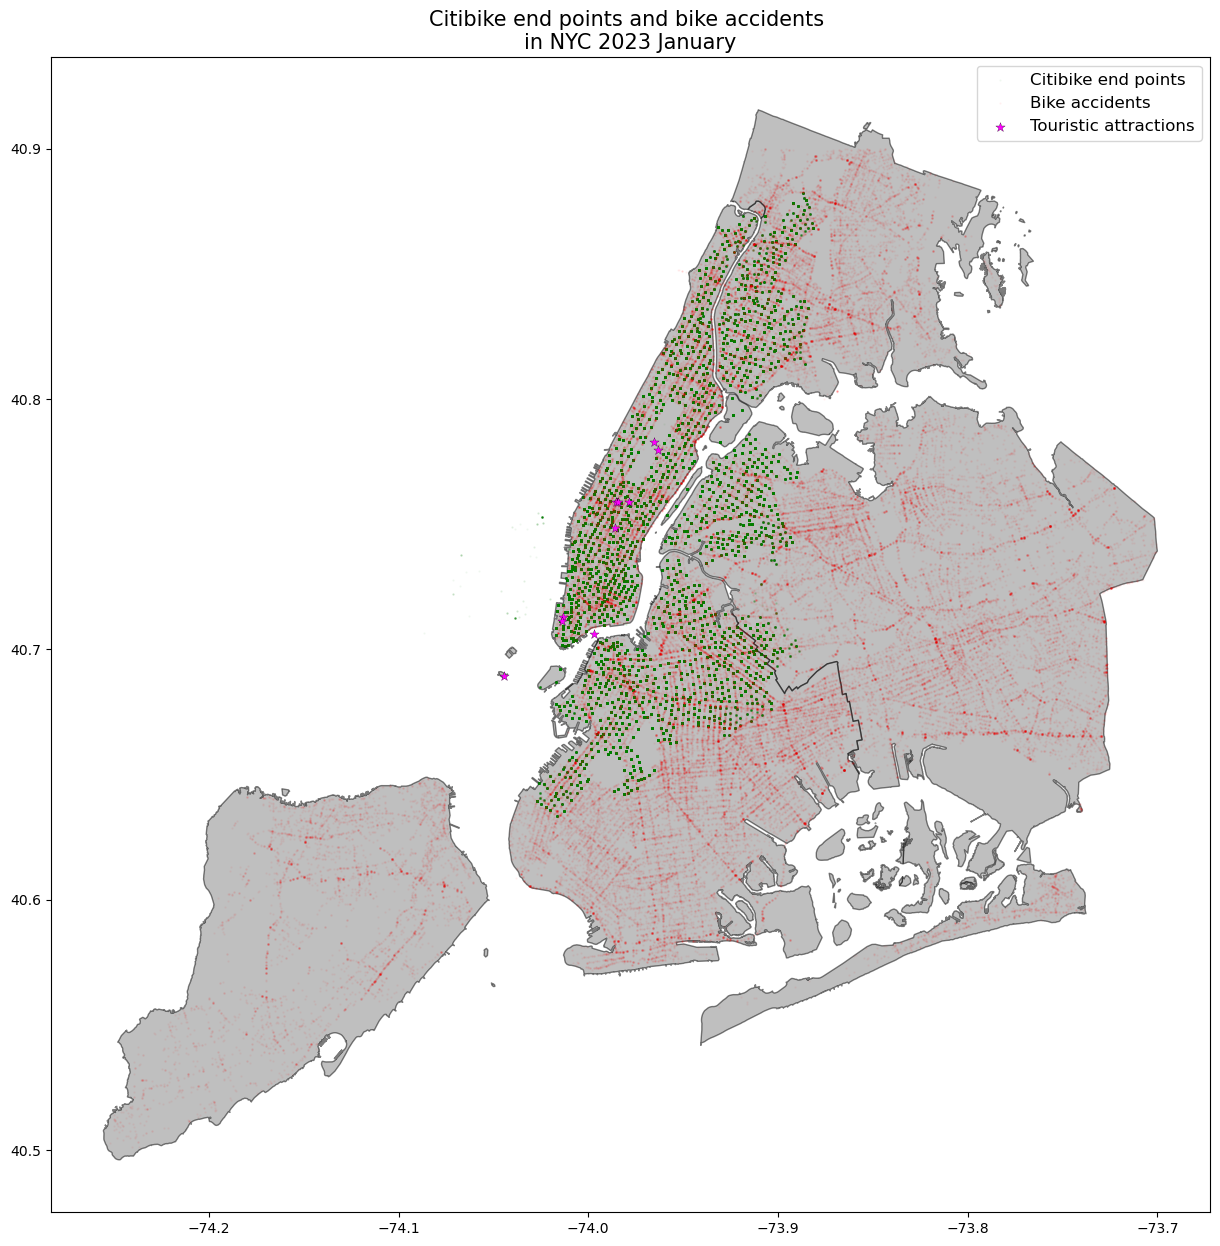

In [11]:
# Plot NY map

# Plot base map
ax = df.plot(figsize=(15,15), alpha=0.5, edgecolor="k", color = "grey")

# Scatter citibike and police points
gdf_c.plot(ax=ax, color="green", markersize=0.3, alpha=0.05, label="Citibike end points", marker="o")
gdf_p.plot(ax=ax, color="red", markersize=0.3, alpha=0.05, label="Bike accidents", marker="o")

# Scatter touristic attractions
gdf_t.plot(ax=ax, color="magenta", edgecolor="black", linewidth=0.2, markersize=50, label="Touristic attractions", marker="*")

plt.legend(scatterpoints=1, fontsize=12, frameon=True)
plt.title("Citibike end points and bike accidents \nin NYC 2023 January", fontsize=15)
plt.show()

First insights
- Most accidents happen on intersections
- Some bikes are returned in water, nearly none in central park
- Touristic attractions have no direct impact on accidents, based on visuals

## 4 Discover data in numbers

In how many accidents are bikes involved? Tourists vs Inhabitants?

In [ ]:
# Filter accidents where bikes are involved
df_p[
    (df_p[['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']].apply(lambda x: x.str.contains('BI', na=False)).any(axis=1)) &
    ((df_p['NUMBER OF CYCLIST INJURED'] > 0) | (df_p['NUMBER OF CYCLIST KILLED'] > 0))
]
# To be continued ...

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
1257124,07/07/2016,8:07,QUEENS,11373,NaN,NaN,NaN,BROADWAY,BAXTER AVENUE,NaN,...,Unspecified,Unspecified,NaN,NaN,3485897,BICYCLE,PASSENGER VEHICLE,BICYCLE,NaN,NaN
1272261,06/17/2016,16:06,BROOKLYN,11203,NaN,NaN,NaN,UTICA AVENUE,RUTLAND ROAD,NaN,...,Unspecified,Unspecified,Unspecified,NaN,3470666,BICYCLE,BICYCLE,NaN,NaN,NaN
1333355,03/07/2016,18:30,NaN,<NA>,NaN,NaN,NaN,ADAMS STREET,JORALEMON STREET,NaN,...,NaN,NaN,NaN,NaN,3401834,UNKNOWN,BICYCLE,NaN,NaN,NaN
1333623,03/06/2016,11:15,STATEN ISLAND,10314,40.612641,-74.128380,"(40.6126406, -74.1283802)",VICTORY BOULEVARD,CLERMONT PLACE,NaN,...,Driver Inattention/Distraction,NaN,NaN,NaN,3401362,PASSENGER VEHICLE,BICYCLE,NaN,NaN,NaN
1333674,02/28/2016,21:40,MANHATTAN,10009,40.727594,-73.985294,"(40.727594, -73.985294)",SAINT MARKS PLACE,1 AVENUE,NaN,...,Illness,NaN,NaN,NaN,3397056,LIVERY VEHICLE,BICYCLE,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104180,07/09/2012,17:37,BROOKLYN,11222,40.720601,-73.954754,"(40.7206006, -73.9547539)",BEDFORD AVENUE,NORTH 12 STREET,NaN,...,Unspecified,NaN,NaN,NaN,198192,TAXI,BICYCLE,NaN,NaN,NaN
2104201,07/02/2012,9:46,MANHATTAN,10002,40.717724,-73.985765,"(40.7177239, -73.9857652)",DELANCEY STREET,CLINTON STREET,NaN,...,Unspecified,NaN,NaN,NaN,12187,PICK-UP TRUCK,BICYCLE,NaN,NaN,NaN
2104269,07/07/2012,18:40,NaN,<NA>,40.867335,-73.822707,"(40.8673349, -73.8227066)",NaN,NaN,NaN,...,Unspecified,NaN,NaN,NaN,2912116,PASSENGER VEHICLE,BICYCLE,NaN,NaN,NaN
2104270,07/06/2012,13:33,BROOKLYN,11209,40.625780,-74.024154,"(40.6257805, -74.0241544)",5 AVENUE,80 STREET,NaN,...,Unspecified,NaN,NaN,NaN,140835,PASSENGER VEHICLE,BICYCLE,NaN,NaN,NaN
